Epoch 1/50


D:\ANACONDA\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3588.1785 - mae: 15.3052 - val_loss: 6.2056 - val_mae: 1.2252
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.2600 - mae: 1.1707 - val_loss: 3.9114 - val_mae: 1.0778
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7941 - mae: 1.0661 - val_loss: 3.5674 - val_mae: 1.0416
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6056 - mae: 1.0421 - val_loss: 3.5786 - val_mae: 1.0357
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.6163 - mae: 1.0394 - val_loss: 4.1509 - val_mae: 1.0662
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.6796 - mae: 1.0409 - val_loss: 3.4620 - val_mae: 1.0246
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.6189 - mae: 1.0394 - val_loss: 3.4519 - val_mae: 1.0256
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.6771 - mae: 1.0413 - val_loss: 3.4970 - val_mae: 1.0300
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3m

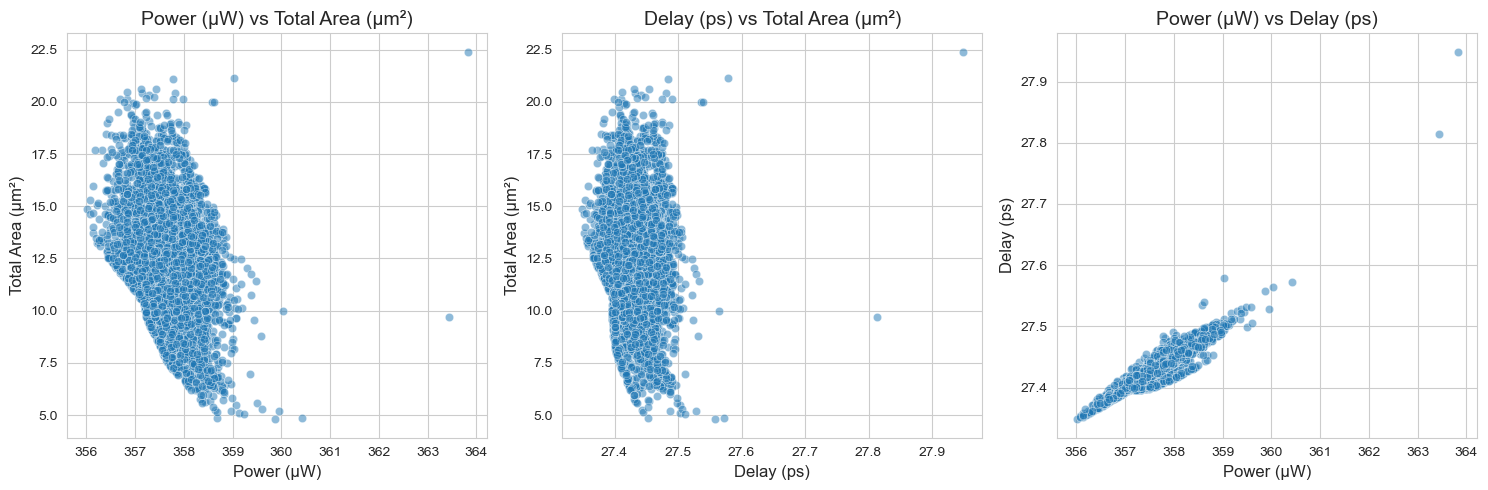

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

# Step 1: Load CSV with Encoding Detection
file_path = r"C:\Users\vivek\Downloads\ltspice_data_pnors.csv"  # Update path to your Pseudo-NMOS NOR CSV

with open(file_path, "rb") as f:
    rawdata = f.read(10000)
    result = chardet.detect(rawdata)
encoding_type = result['encoding']

try:
    data = pd.read_csv(file_path, encoding=encoding_type)
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding="latin1")

# Step 2: Add Total Widths (Keep Individual Widths Too)
# For Pseudo-NMOS NOR, adjust transistor naming as per your CSV
# Assuming NMOS transistors are named NMOS1_W, NMOS2_W, NMOS3_W, NMOS4_W
# and only one PMOS transistor named PMOS_W (Pseudo-NMOS typically has one PMOS pull-up)
data['NMOS_Total_Width'] = data['NMOS1_W'] + data['NMOS2_W'] + data['NMOS3_W'] + data['NMOS4_W']
# PMOS total width is just PMOS_W (single transistor)
data['PMOS_Total_Width'] = data['PMOS_W']

# Step 3: Define Features and Target Labels
feature_columns = ['NMOS_Total_Width', 'PMOS_Total_Width', 'VDD']  # Inputs to model
target_columns = [
    'Power (µW)', 'Delay (ps)', 'Total Area (µm²)', 'Rise Time (ps)', 'Fall Time (ps)',
    'Energy (fJ)', 'Leakage Power (nW)', 'Output Swing (V)', 'Noise Margin High (V)',
    'Noise Margin Low (V)', 'Threshold Voltage (V)', 'Load Capacitance (fF)', 'Gate Overdrive (V)'
]

X = data[feature_columns].values
y = data[target_columns].values

# Step 4: Normalize Inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(
    X_scaled, y, data.index, test_size=0.2, random_state=42
)

# Step 6: Define the Neural Network
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(len(target_columns))  # Output layer for all targets
])

# Step 7: Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 8: Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

# Step 9: Predict & Evaluate
y_pred = model.predict(X_test)
mae_scores = {target_columns[i]: mean_absolute_error(y_test[:, i], y_pred[:, i]) for i in range(len(target_columns))}

# Step 10: Display Performance
print("\n📊 Neural Network Model Performance (PPA Prediction for Pseudo-NMOS NOR Gate)")
for target, mae in mae_scores.items():
    print(f"{target} - Mean Absolute Error (MAE): {mae:.4f}")

# Step 11: Save Predictions with all transistor widths + VDD
original_inputs = data.loc[index_test, ['NMOS1_W', 'NMOS2_W', 'NMOS3_W', 'NMOS4_W', 'PMOS_W', 'VDD']].reset_index(drop=True)
predictions_df = pd.DataFrame(y_pred, columns=target_columns)
final_output = pd.concat([original_inputs, predictions_df], axis=1)
final_output.insert(0, 'Index', np.arange(len(final_output)))

output_file = r"C:\Users\vivek\Downloads\pseudo_nmos_nor_predictions.csv"
final_output.to_csv(output_file, index=False)
print(f"\n✅ Predicted values (with transistor widths + VDD) saved to: {output_file}")

# Step 12: Plot PPA Relationships
sns.set_style("whitegrid")
plot_pairs = [("Power (µW)", "Total Area (µm²)"), ("Delay (ps)", "Total Area (µm²)"), ("Power (µW)", "Delay (ps)")]

plt.figure(figsize=(15, 5))
for i, (x_col, y_col) in enumerate(plot_pairs, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=predictions_df[x_col], y=predictions_df[y_col], alpha=0.5)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.title(f"{x_col} vs {y_col}", fontsize=14)

plt.tight_layout()
plt.show()


📊 Pseudo-NMOS NOR Gate Model Performance (Random Forest)
Power (µW) - Mean Absolute Error (MAE): 4.4457
Delay (ps) - Mean Absolute Error (MAE): 0.6939
Total Area (µm²) - Mean Absolute Error (MAE): 1.2248

✅ Output sheet saved at: C:\Users\vivek\Downloads\PseudoNMOS_NOR_RF_predictions_20250516_142419.csv


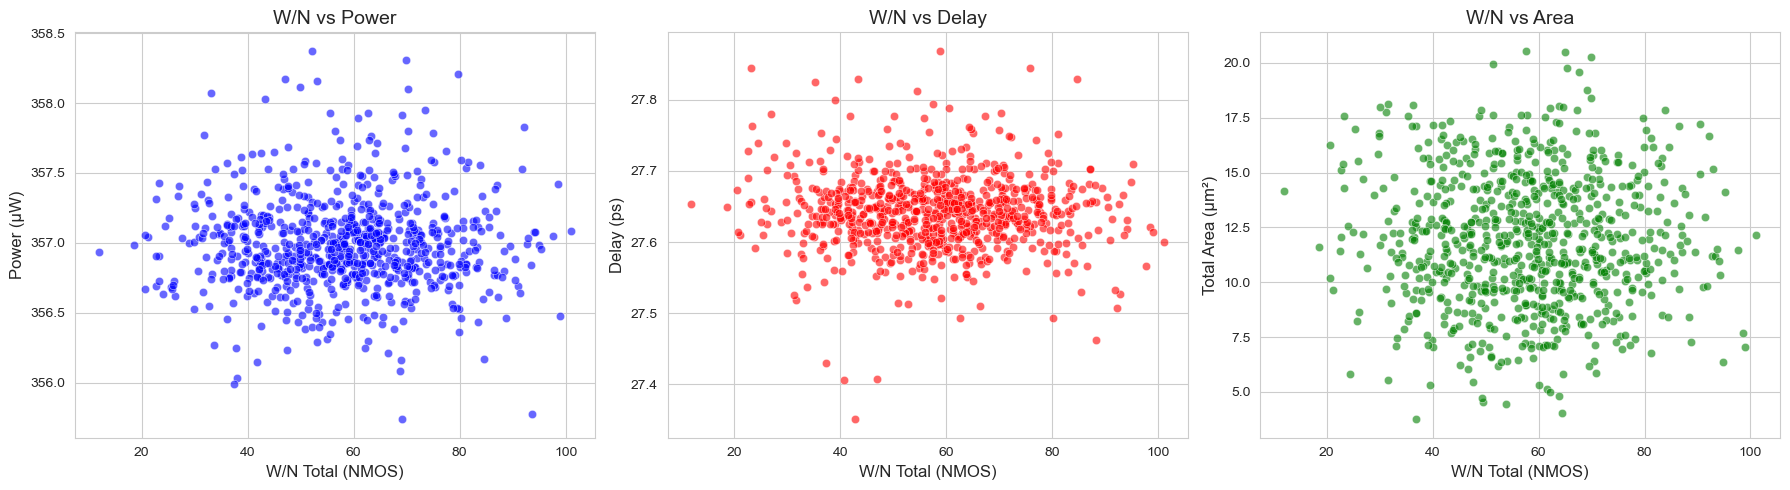

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import datetime

# Step 1: Detect File Encoding
file_path = r"C:\Users\vivek\Downloads\ltspice_data_pnors.csv"    # Update path for your Pseudo-NMOS NOR data
with open(file_path, "rb") as f:
    result = chardet.detect(f.read())
encoding_type = result['encoding']

# Step 2: Load LTspice Data
try:
    data = pd.read_csv(file_path, encoding=encoding_type)
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding="latin1")

# Step 3: Compute Total Widths
# Pseudo-NMOS NOR typically has 4 NMOS and 1 PMOS transistor (pull-up)
data['NMOS_Total_Width'] = data['NMOS1_W'] + data['NMOS2_W'] + data['NMOS3_W'] + data['NMOS4_W']
data['PMOS_Total_Width'] = data['PMOS_W']  # Only one PMOS transistor

# Step 4: Define Features and Targets
feature_columns = ['NMOS1_W', 'NMOS2_W', 'NMOS3_W', 'NMOS4_W', 'PMOS_W',
                   'NMOS_Total_Width', 'PMOS_Total_Width', 'VDD']

target_columns = ['Power (µW)', 'Delay (ps)', 'Total Area (µm²)']

X = data[feature_columns]
y = data[target_columns]

# Step 5: Calculate Width/Length Ratio for NMOS (L = 0.18 µm)
L = 0.18
data['W/N_NMOS_Total'] = data['NMOS_Total_Width'] / L

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 7: Train Random Forest Regressors
models = {}
for target in target_columns:
    model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    model.fit(X_train, y_train[target])
    models[target] = model

# Step 8: Predict and Evaluate
predictions = {}
mae_scores = {}
for target in target_columns:
    y_pred = models[target].predict(X_test)
    predictions[target] = y_pred
    mae_scores[target] = mean_absolute_error(y_test[target], y_pred)

# Step 9: Display Model Performance
print("\n📊 Pseudo-NMOS NOR Gate Model Performance (Random Forest)")
for target, mae in mae_scores.items():
    print(f"{target} - Mean Absolute Error (MAE): {mae:.4f}")

# Step 10: Prepare Prediction DataFrame
df_pred = pd.DataFrame(predictions, columns=target_columns)
df_pred['W/N_NMOS_Total'] = (X_test['NMOS1_W'] + X_test['NMOS2_W'] + X_test['NMOS3_W'] + X_test['NMOS4_W']) / L

# Step 11: Add Transistor Widths to Output
df_pred['NMOS1_W'] = X_test['NMOS1_W'].values
df_pred['NMOS2_W'] = X_test['NMOS2_W'].values
df_pred['NMOS3_W'] = X_test['NMOS3_W'].values
df_pred['NMOS4_W'] = X_test['NMOS4_W'].values
df_pred['PMOS_W'] = X_test['PMOS_W'].values
df_pred['VDD'] = X_test['VDD'].values

# Step 12: Save Output to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = fr"C:\Users\vivek\Downloads\PseudoNMOS_NOR_RF_predictions_{timestamp}.csv"
df_pred.to_csv(output_path, index=False)
print(f"\n✅ Output sheet saved at: {output_path}")

# Step 13: Plot Results
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# W/N vs Power
sns.scatterplot(x=df_pred['W/N_NMOS_Total'], y=df_pred['Power (µW)'], ax=axes[0], color="blue", alpha=0.6)
axes[0].set_xlabel("W/N Total (NMOS)", fontsize=12)
axes[0].set_ylabel("Power (µW)", fontsize=12)
axes[0].set_title("W/N vs Power", fontsize=14)

# W/N vs Delay
sns.scatterplot(x=df_pred['W/N_NMOS_Total'], y=df_pred['Delay (ps)'], ax=axes[1], color="red", alpha=0.6)
axes[1].set_xlabel("W/N Total (NMOS)", fontsize=12)
axes[1].set_ylabel("Delay (ps)", fontsize=12)
axes[1].set_title("W/N vs Delay", fontsize=14)

# W/N vs Area
sns.scatterplot(x=df_pred['W/N_NMOS_Total'], y=df_pred['Total Area (µm²)'], ax=axes[2], color="green", alpha=0.6)
axes[2].set_xlabel("W/N Total (NMOS)", fontsize=12)
axes[2].set_ylabel("Total Area (µm²)", fontsize=12)
axes[2].set_title("W/N vs Area", fontsize=14)

plt.tight_layout()
plt.show()

Epoch 1/50


D:\ANACONDA\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 16640.0762 - mae: 60.4241 - val_loss: 137.0496 - val_mae: 6.2440
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 86.9669 - mae: 4.8784 - val_loss: 18.8924 - val_mae: 2.3997
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.2674 - mae: 2.2600 - val_loss: 10.9813 - val_mae: 1.9467
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.6783 - mae: 1.9423 - val_loss: 9.7801 - val_mae: 1.8759
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.0154 - mae: 1.8863 - val_loss: 10.4690 - val_mae: 1.8925
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.7397 - mae: 1.8568 - val_loss: 10.1963 - val_mae: 1.8708
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.2318 - mae: 1.8977 - val_loss: 9.6346 - val_mae: 1.8396
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.0993 - mae: 1.8820 - val_loss: 10.6551 - val_mae: 1.9083
Epoch 9/50
1000/1000 ━━━━━━━━━━━━

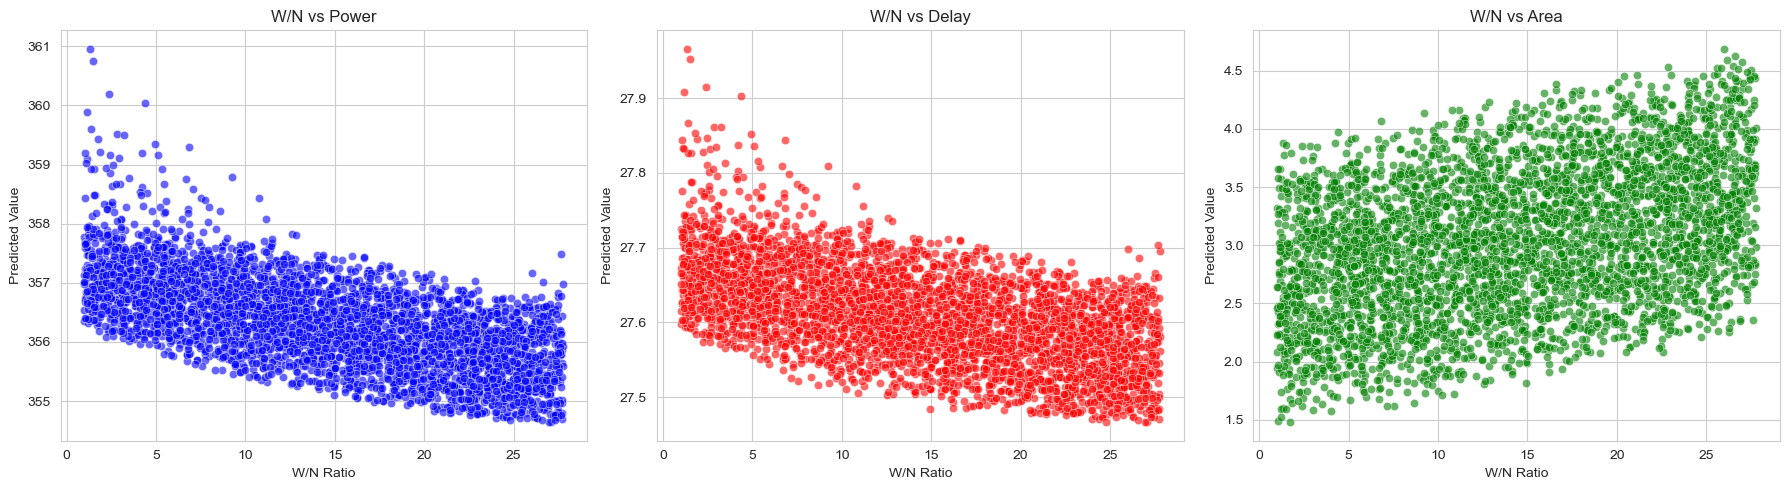

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from datetime import datetime

# Step 1: Detect File Encoding
file_path = r"C:\Users\vivek\Downloads\ltspice_data_pnors.csv"  
with open(file_path, "rb") as f:
    result = chardet.detect(f.read())
encoding_type = result['encoding']

# Step 2: Load Data
try:
    data = pd.read_csv(file_path, encoding=encoding_type)
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding="latin1")

# Step 3: Define Inputs and Outputs
feature_columns = ['NMOS1_W', 'NMOS2_W', 'PMOS_W', 'VDD']  # Only one PMOS in pseudo-NMOS
target_columns = ['Power (µW)', 'Delay (ps)', 'Area (µm²)']

# Optional additional outputs from simulation
additional_outputs = [
    'Rise Time (ps)', 'Fall Time (ps)', 'Energy (fJ)', 'Leakage Power (nW)',
    'Output Swing (V)', 'Noise Margin High (V)', 'Noise Margin Low (V)',
    'Threshold Voltage (V)', 'Load Capacitance (fF)', 'Gate Overdrive (V)'
]

X = data[feature_columns].values
y = data[target_columns].values

# Step 4: Compute W/N ratio (assuming L = 0.18 µm)
L = 0.18
data['W/N_NMOS1'] = data['NMOS1_W'] / L
data['W/N_NMOS2'] = data['NMOS2_W'] / L
data['W/N_Total'] = (data['NMOS1_W'] + data['NMOS2_W']) / L

# Step 5: Normalize Inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Split Dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, data.index, test_size=0.2, random_state=42
)

# Step 7: Build Neural Network Model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(len(target_columns))
])

# Step 8: Compile and Train
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# Step 9: Predictions
y_pred = model.predict(X_test)

# Step 10: MAE
mae_scores = {target_columns[i]: mean_absolute_error(y_test[:, i], y_pred[:, i]) for i in range(len(target_columns))}
print("\n📊 Mean Absolute Error (Pseudo-NMOS NOR):")
for param, mae in mae_scores.items():
    print(f"{param}: {mae:.4f}")

# Step 11: Extract Original Widths
nmos1_w = data.loc[idx_test, 'NMOS1_W'].values
nmos2_w = data.loc[idx_test, 'NMOS2_W'].values
pmos_w = data.loc[idx_test, 'PMOS_W'].values

# Step 12: Final Output DataFrame
predicted_df = pd.DataFrame({
    'NMOS1_W': nmos1_w,
    'NMOS2_W': nmos2_w,
    'PMOS_W': pmos_w,
    'Power': y_pred[:, 0],
    'Delay': y_pred[:, 1],
    'Area': y_pred[:, 2]
})

# Step 13: Add Additional Columns
additional_df = data.loc[idx_test, additional_outputs].reset_index(drop=True)
final_df = pd.concat([predicted_df, additional_df], axis=1)

# Step 14: Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = fr"C:\Users\vivek\Downloads\PseudoNMOS_NOR_NN_Predictions.csv"
final_df.to_csv(output_path, index=False)
print(f"\n✅ Results saved to: {output_path}")

# Step 15: Plot W/N Ratio vs PPA
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

W_N_ratio = predicted_df['NMOS1_W'] / L

sns.scatterplot(x=W_N_ratio, y=predicted_df['Power'], ax=axes[0], color="blue", alpha=0.6)
axes[0].set_title("W/N vs Power")

sns.scatterplot(x=W_N_ratio, y=predicted_df['Delay'], ax=axes[1], color="red", alpha=0.6)
axes[1].set_title("W/N vs Delay")

sns.scatterplot(x=W_N_ratio, y=predicted_df['Area'], ax=axes[2], color="green", alpha=0.6)
axes[2].set_title("W/N vs Area")

for ax in axes:
    ax.set_xlabel("W/N Ratio")
    ax.set_ylabel("Predicted Value")

plt.tight_layout()
plt.show()


Running GA for Priority: ALL
→ Optimized Widths: NMOS1 = 3.598, NMOS2 = 0.842, NMOS3 = 3.832, NMOS4 = 1.557, PMOS = 0.854
  Predicted: Power = 357.55 µW, Delay = 27.42 ps, Area = 8.90 µm²

Running GA for Priority: AREA_POWER
→ Optimized Widths: NMOS1 = 0.565, NMOS2 = 1.165, NMOS3 = 4.659, NMOS4 = 2.868, PMOS = 0.837
  Predicted: Power = 357.74 µW, Delay = 27.41 ps, Area = 8.06 µm²

Running GA for Priority: DELAY_POWER
→ Optimized Widths: NMOS1 = 4.451, NMOS2 = 2.598, NMOS3 = 4.971, NMOS4 = 0.753, PMOS = 1.104
  Predicted: Power = 357.37 µW, Delay = 27.42 ps, Area = 9.91 µm²

Running GA for Priority: DELAY_AREA
→ Optimized Widths: NMOS1 = 2.817, NMOS2 = 2.462, NMOS3 = 0.564, NMOS4 = 0.859, PMOS = 0.596
  Predicted: Power = 358.08 µW, Delay = 27.43 ps, Area = 6.53 µm²

Running GA for Priority: POWER
→ Optimized Widths: NMOS1 = 2.316, NMOS2 = 4.342, NMOS3 = 4.947, NMOS4 = 1.860, PMOS = 0.993
  Predicted: Power = 356.76 µW, Delay = 27.39 ps, Area = 11.96 µm²

Running GA for Priority: DELA

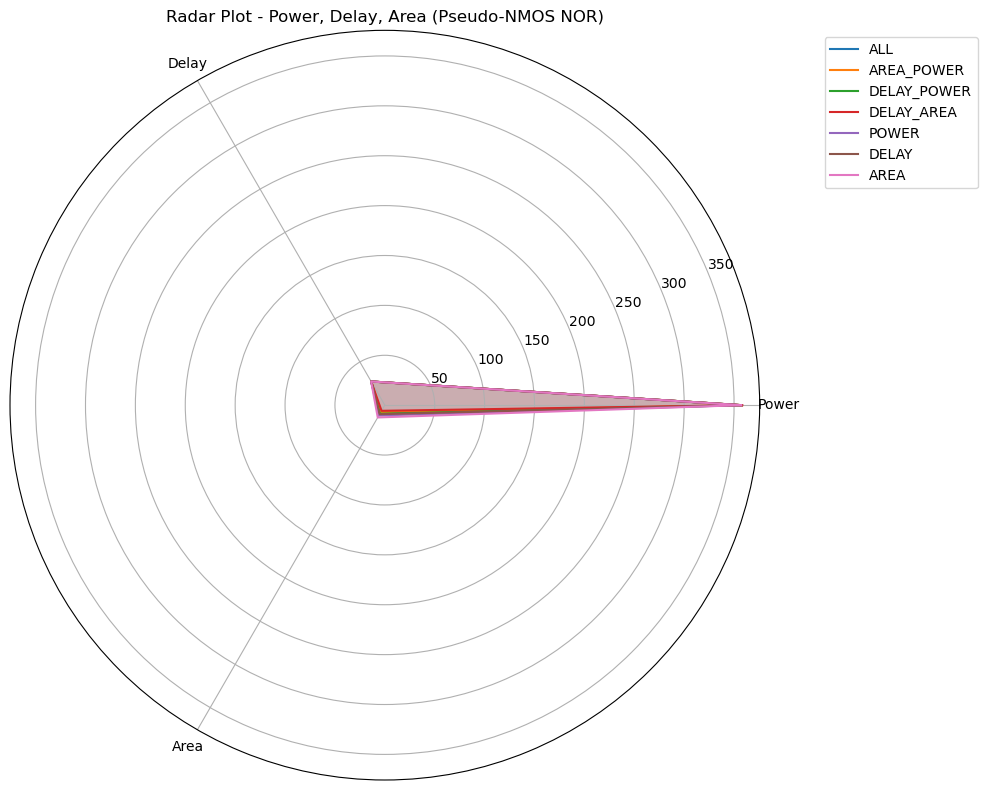

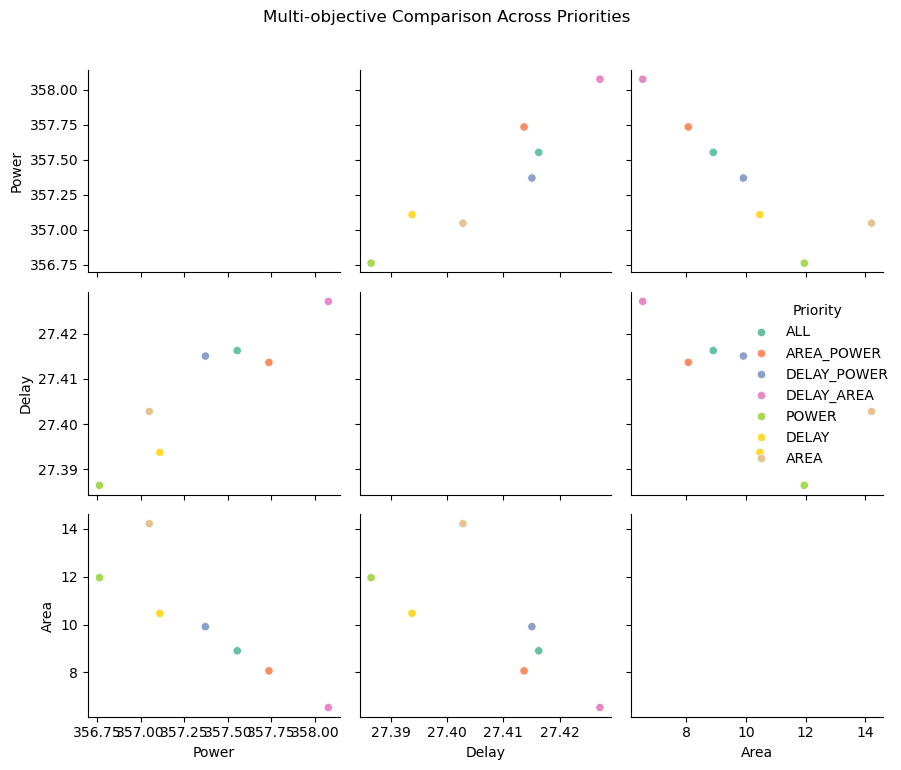

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns

# Load dataset for Pseudo-NMOS NOR gate
data = pd.read_csv(r"C:\Users\vivek\Downloads\pseudo_nmos_nor_predictions.csv")

# Define input and output
X = data[['NMOS1_W', 'NMOS2_W', 'NMOS3_W', 'NMOS4_W', 'PMOS_W']].values
Y = data[['Power (µW)', 'Delay (ps)', 'Total Area (µm²)']].values

# Normalize inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train KNN model
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, Y_train)

# GA setup
if "FitnessMulti" not in creator.__dict__:
    creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.5, 5.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

# Bound check decorator
def check_bounds(min_val, max_val):
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for ind in offspring:
                for i in range(len(ind)):
                    ind[i] = max(min_val, min(ind[i], max_val))
            return offspring
        return wrapper
    return decorator

MIN_WIDTH = 0.05
MAX_WIDTH = 5.0
toolbox.decorate("mate", check_bounds(MIN_WIDTH, MAX_WIDTH))
toolbox.decorate("mutate", check_bounds(MIN_WIDTH, MAX_WIDTH))

# Evaluation function
def get_evaluator(priority):
    def evaluate(ind):
        input_scaled = scaler.transform([ind])
        power, delay, area = model.predict(input_scaled)[0]
        if priority == 'all': return power, delay, area
        if priority == 'area_power': return power, 0, area
        if priority == 'delay_power': return power, delay, 0
        if priority == 'delay_area': return 0, delay, area
        if priority == 'power': return power, 0, 0
        if priority == 'delay': return 0, delay, 0
        if priority == 'area': return 0, 0, area
        return power, delay, area
    return evaluate

# Run GA
priorities = ['all', 'area_power', 'delay_power', 'delay_area', 'power', 'delay', 'area']
results, outputs, pareto_data, comparison_df = {}, {}, {}, []

for priority in priorities:
    print(f"\nRunning GA for Priority: {priority.upper()}")
    try: toolbox.unregister("evaluate")
    except: pass
    toolbox.register("evaluate", get_evaluator(priority))

    pop = toolbox.population(n=40)
    hof = tools.ParetoFront()
    
    for gen in range(30):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.7, mutpb=0.2)
        for ind in offspring:
            ind.fitness.values = toolbox.evaluate(ind)
        pop = toolbox.select(pop + offspring, k=40)
        hof.update(pop)

    best = tools.selBest(pop, k=1)[0]
    results[priority] = best
    power, delay, area = model.predict(scaler.transform([best]))[0]
    outputs[priority] = (*best, power, delay, area)
    pareto_data[priority] = [(ind[0], ind[1], ind[2], ind[3], ind[4], *model.predict(scaler.transform([ind]))[0]) for ind in pop]

    comparison_df.append({'Priority': priority.upper(), 'Power': power, 'Delay': delay, 'Area': area})
    print(f"→ Optimized Widths: NMOS1 = {best[0]:.3f}, NMOS2 = {best[1]:.3f}, NMOS3 = {best[2]:.3f}, NMOS4 = {best[3]:.3f}, PMOS = {best[4]:.3f}")
    print(f"  Predicted: Power = {power:.2f} µW, Delay = {delay:.2f} ps, Area = {area:.2f} µm²")

print("\nFinal Optimized Results:")
for priority in priorities:
    n1, n2, n3, n4, p, power, delay, area = outputs[priority]
    print(f"{priority.upper()}: NMOS1 = {n1:.3f}, NMOS2 = {n2:.3f}, NMOS3 = {n3:.3f}, NMOS4 = {n4:.3f}, PMOS = {p:.3f} → Power = {power:.2f} µW, Delay = {delay:.2f} ps, Area = {area:.2f} µm²")

# Radar Plot
labels = ['Power', 'Delay', 'Area']
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))] + [0]
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

for priority in priorities:
    values = list(outputs[priority][5:]) + [outputs[priority][5]]
    ax.plot(angles, values, label=priority.upper())
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Radar Plot - Power, Delay, Area (Pseudo-NMOS NOR)")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

# Pairplot Comparison
comparison_df = pd.DataFrame(comparison_df)
sns.pairplot(comparison_df, hue="Priority", diag_kind='kde', palette='Set2')
plt.suptitle("Multi-objective Comparison Across Priorities", y=1.02)
plt.tight_layout()
plt.show()
